#PhlyGreen Tutorial 

Import packages

In [1]:
import PhlyGreen as pg
import numpy as np
import matplotlib.pyplot as plt

Create instances of subsystems. Each one of those requires an Aircraft object as argument. By passing (None) as argument, we are creating empty objects (for the moment).

In [2]:
powertrain = pg.Systems.Powertrain.Powertrain(None)
structures = pg.Systems.Structures.Structures(None)
aerodynamics = pg.Systems.Aerodynamics.Aerodynamics(None)
performance = pg.Performance.Performance(None)
mission = pg.Mission.Mission(None)
weight = pg.Weight.Weight(None)
constraint = pg.Constraint.Constraint(None)
welltowake = pg.WellToWake.WellToWake(None)

Create instance of Aircraft object.

In [3]:
myaircraft = pg.Aircraft(powertrain, structures, aerodynamics, performance, mission, weight, constraint, welltowake)

Create the connections with its subsystems.

In [4]:
powertrain.aircraft = myaircraft
structures.aircraft = myaircraft
aerodynamics.aircraft = myaircraft
mission.aircraft = myaircraft
performance.aircraft = myaircraft
weight.aircraft = myaircraft
constraint.aircraft = myaircraft
welltowake.aircraft = myaircraft

Define input dictionaries

Constraints ordering:
[0] : cruise,
[1] : take-off,
[2] : climb,
[3] : turn,
[4] : ceiling,
[5] : acceleration,
[6] : landing 

In [5]:
ConstraintsInput = {'speed': np.array([0.5, 90, 210, 210, 0.5, 0.35, 59.]) ,
                    'speedtype': ['Mach','TAS','KCAS','KCAS','Mach','Mach','TAS']   ,
                    'beta': np.array([0.95,1.,0.97, 0.9, 0.8, 0.9, None])   ,
                    'altitude': np.array([8000., 100., 6000., 5000, 9500., 6000, 500.]),
                    'load factor': np.array([1., None, 1., 1.1, 1., 1., None]),
                    'DISA': 0, 
                    'kTO': 1.2,
                    'sTO': 950,
                    'OEI Climb Gradient': 0.021,
                    'Rate of Climb': 5,  #5m/s ~= 1000 ft/min, 7.6 ~= 1500 ft/min
                    'ht': 0.5,
                    'M1': 0.3,
                    'M2': 0.4,
                    'DTAcceleration': 180}

In [6]:
MissionInput = {'Range Mission': 1400,
                'Range Diversion': 150,
                'Beta start': 0.95,
                'Payload Weight': (4560),
                'Crew Weight': (95*3)}

In [7]:
MissionStages = {'Climb1': {'type': 'ConstantRateClimb', 'input': {'CB': 0.16, 'Speed': 77, 'StartAltitude': 100, 'EndAltitude': 1500}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }},
                 'Climb2': {'type': 'ConstantRateClimb', 'input': {'CB': 0.08, 'Speed': 125, 'StartAltitude': 1500, 'EndAltitude': 4500}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }},
                 'Climb3': {'type': 'ConstantRateClimb', 'input': {'CB': 0.04, 'Speed': 160, 'StartAltitude': 4500, 'EndAltitude': 8000}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }},
                 'Cruise': {'type': 'ConstantMachCruise', 'input':{ 'Mach': 0.5, 'Altitude': 8000}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }},
                 'Descent1': {'type': 'ConstantRateDescent', 'input':{'CB': -0.04, 'Speed': 100, 'StartAltitude': 8000, 'EndAltitude': 200}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }}}

DiversionStages = {'Climb1': {'type': 'ConstantRateClimb', 'input': {'CB': 0.08, 'Speed': 1.4*59, 'StartAltitude': 200, 'EndAltitude': 3100}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }},
                 'Cruise': {'type': 'ConstantMachCruise', 'input':{ 'Mach': 0.3, 'Altitude': 3100}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0}},
                 'Descent1': {'type': 'ConstantRateDescent', 'input':{'CB': -0.04, 'Speed': 110, 'StartAltitude': 3100, 'EndAltitude': 200}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }}}

In [18]:
EnergyInput = {'Ef': 43.5*10**6,
                   'Eta Gas Turbine Model': 'constant',
                   'Eta Gas Turbine': 0.3,
                   'Eta Gearbox': 0.96,
                   'Eta Propulsive': 0.9,
                   'Specific Power Powertrain': [3600,0]
                   }

In [9]:
AerodynamicsInput = {'AnalyticPolar': {'type': 'Quadratic', 'input': {'AR': 11, 'e_osw': 0.8}}}

Import input dictionaries

In [19]:
myaircraft.ConstraintsInput = ConstraintsInput
myaircraft.AerodynamicsInput = AerodynamicsInput
myaircraft.MissionInput = MissionInput
myaircraft.MissionStages = MissionStages
myaircraft.DiversionStages = DiversionStages
myaircraft.EnergyInput = EnergyInput

Set aircraft power configuration

In [11]:
myaircraft.Configuration = 'Traditional'

Set inputs

In [20]:
# Initialize Constraint Analysis
myaircraft.constraint.SetInput()

# Initialize Mission profile and Analysis
myaircraft.mission.InitializeProfile()
myaircraft.mission.SetInput()

# Initialize Aerodynamics subsystem
myaircraft.aerodynamics.SetInput()

# Initialize Powertrain
myaircraft.powertrain.SetInput()

# Initialize Weight Estimator
myaircraft.weight.SetInput()

Either run the Constraint Analysis....

In [25]:
myaircraft.constraint.FindDesignPoint()
print('----------------------------------------')
print('Design W/S: ',myaircraft.DesignWTOoS)
print('Design P/W: ',myaircraft.DesignPW)
print('----------------------------------------')

----------------------------------------
Design W/S:  3253.0606060606065
Design P/W:  195.34870676278987
----------------------------------------


... or assign a wing loading

In [26]:
#myaircraft.DesignWTOoS = 2121

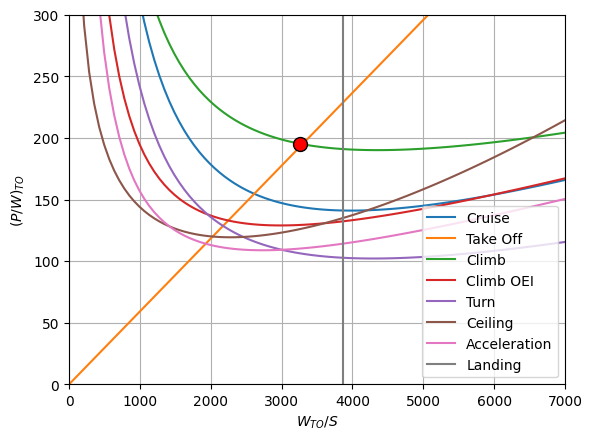

In [27]:
plt.plot(myaircraft.constraint.WTOoS,myaircraft.constraint.PWCruise, label='Cruise')
plt.plot(myaircraft.constraint.WTOoS,myaircraft.constraint.PWTakeOff, label='Take Off')
plt.plot(myaircraft.constraint.WTOoS,myaircraft.constraint.PWClimb, label='Climb')
plt.plot(myaircraft.constraint.WTOoS,myaircraft.constraint.PWOEI, label='Climb OEI')
plt.plot(myaircraft.constraint.WTOoS,myaircraft.constraint.PWTurn, label='Turn')
plt.plot(myaircraft.constraint.WTOoS,myaircraft.constraint.PWCeiling, label='Ceiling')
plt.plot(myaircraft.constraint.WTOoS,myaircraft.constraint.PWAcceleration, label='Acceleration')
plt.plot(myaircraft.constraint.WTOoSLanding,myaircraft. constraint.PWLanding, label='Landing')
plt.plot(myaircraft.DesignWTOoS, myaircraft.DesignPW, marker='o', markersize = 10, markerfacecolor = 'red', markeredgecolor = 'black')
# plt.plot(performance.WTOoSTorenbeek, performance.PWTorenbeek, label='Torenbeek')
plt.ylim([0, 300])
plt.xlim([0, 7000])
plt.legend()
plt.grid(visible=True)
plt.xlabel('$W_{TO}/S$')
plt.ylabel('$(P/W)_{TO}$')
plt.show()

Run Mission analysis to define the aircraft's masses

In [28]:
myaircraft.weight.WeightEstimation()

Wing surface can be readily estimated as S = WTO/(WTO/S)

In [29]:
myaircraft.WingSurface = myaircraft.weight.WTO / myaircraft.DesignWTOoS * myaircraft.performance.g_acc 

A summary of the preliminary design:

In [30]:
print('----------------------------------------')
print('Powertrain mass: ',myaircraft.weight.WPT)
print('Fuel mass: ', myaircraft.weight.Wf)
print('Structure: ', myaircraft.weight.WStructure)
print('Empty Weight: ', myaircraft.weight.WPT + myaircraft.weight.WStructure + myaircraft.weight.WCrew)
print('----------------------------------------')
print('Takeoff Weight: ', myaircraft.weight.WTO)
if myaircraft.WellToTankInput is not None:
    print('Source Energy: ', myaircraft.welltowake.SourceEnergy/1.e6,' MJ')
    print('Psi: ', myaircraft.welltowake.Psi)
print('Wing Surface: ', myaircraft.WingSurface, ' m^2')
print('Sizing phase for thermal powertrain ', 'Climb/Cruise peak power' if myaircraft.mission.Max_PF > myaircraft.mission.TO_PF else 'Takeoff peak power'  )

----------------------------------------
Powertrain mass:  1003.6995524851717
Fuel mass:  2294.9298287708903
Structure:  11198.058361340121
Empty Weight:  12486.757913825293
----------------------------------------
Takeoff Weight:  19341.64992820557
Wing Surface:  58.32709831541382  m^2
Sizing phase for thermal powertrain  Climb/Cruise peak power


Some plots:

In [31]:
times = np.array([])
Ef = np.array([])
beta = np.array([])
for array in mission.integral_solution:
    times = np.concatenate([times, array.t])
    Ef = np.concatenate([Ef, array.y[0]])
    beta = np.concatenate([beta, array.y[1]])

Take-Off Propulsive Power

In [32]:
myaircraft.performance.TakeOff(myaircraft.DesignWTOoS,myaircraft.constraint.ConstraintsBeta[1], myaircraft.constraint.ConstraintsAltitude[1], myaircraft.constraint.kTO, myaircraft.constraint.sTO, myaircraft.constraint.DISA, myaircraft.constraint.ConstraintsSpeed[1], myaircraft.constraint.ConstraintsSpeedtype[1])

192.4765605833035

Maximum mission Propusive Power

In [33]:
max([myaircraft.performance.PoWTO(myaircraft.DesignWTOoS,beta[t],myaircraft.mission.profile.PowerExcess(times[t]),1,myaircraft.mission.profile.Altitude(times[t]),myaircraft.mission.DISA,myaircraft.mission.profile.Velocity(times[t]),'TAS') for t in range(len(times))])

161.40807860126895

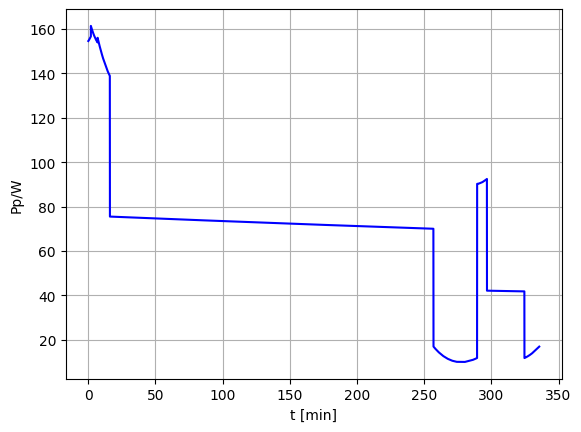

In [34]:
plt.plot(times/60,[myaircraft.performance.PoWTO(myaircraft.DesignWTOoS,beta[t],myaircraft.mission.profile.PowerExcess(times[t]),1,myaircraft.mission.profile.Altitude(times[t]),myaircraft.mission.DISA,myaircraft.mission.profile.Velocity(times[t]),'TAS') for t in range(len(times))], 'b')
plt.grid(visible=True)
plt.xlabel('t [min]')
plt.ylabel('Pp/W')
plt.show()

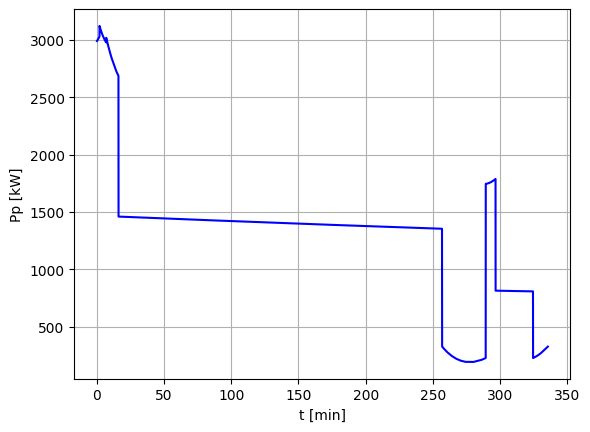

In [35]:
plt.plot(times/60,[(myaircraft.weight.WTO/1000) * myaircraft.performance.PoWTO(myaircraft.DesignWTOoS,beta[t],myaircraft.mission.profile.PowerExcess(times[t]),1,myaircraft.mission.profile.Altitude(times[t]),myaircraft.mission.DISA,myaircraft.mission.profile.Velocity(times[t]),'TAS') for t in range(len(times))], 'b')
plt.grid(visible=True)
plt.xlabel('t [min]')
plt.ylabel('Pp [kW]')
plt.show()

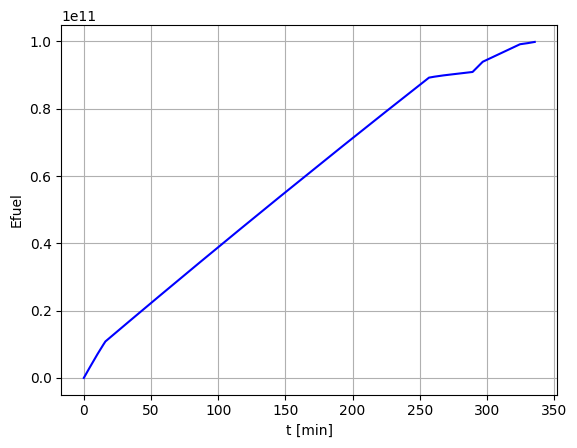

In [36]:
plt.plot(times/60,Ef, 'b')
#plt.plot(myaircraft.mission.profile.Breaks,np.ones(6)*0.05, '*')
plt.grid(visible=True)
plt.xlabel('t [min]')
plt.ylabel('Efuel')
plt.show()

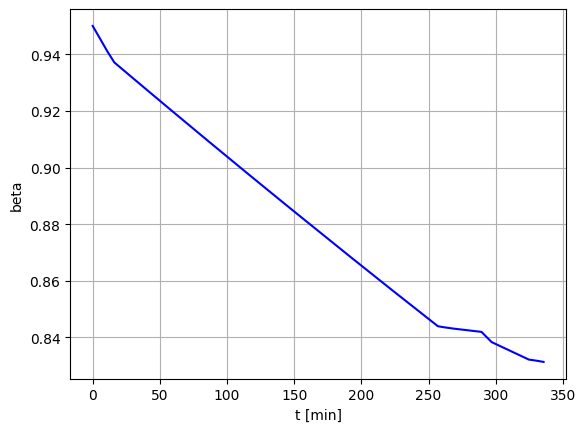

In [37]:
plt.plot(times/60,beta, 'b')
#plt.plot(myaircraft.mission.profile.Breaks,np.ones(6)*0.05, '*')
plt.grid(visible=True)
plt.xlabel('t [min]')
plt.ylabel('beta')
plt.show()

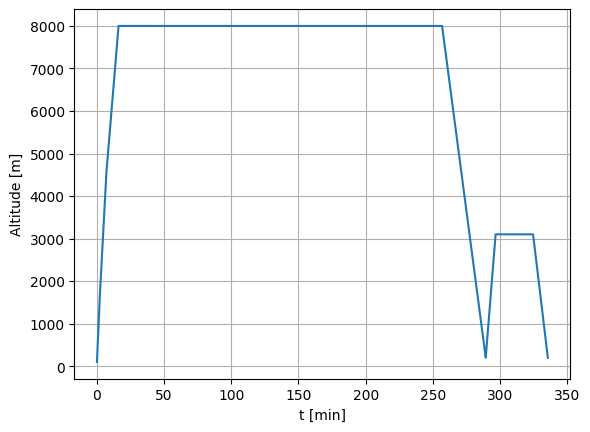

In [38]:
plt.plot(times/60,mission.profile.Altitude(times))
plt.grid(visible=True)
plt.xlabel('t [min]')
plt.ylabel('Altitude [m]')
plt.show()

Compute Payload - Range diagram


In [39]:
from scipy.optimize import brenth 

In [40]:
maxFuelCapacity = 4500 #Kg
MTOW = myaircraft.weight.WTO #Kg
MZFW = myaircraft.weight.WPT + myaircraft.weight.WStructure + myaircraft.weight.WCrew + myaircraft.weight.WPayload #Kg 
OEW = myaircraft.weight.WPT + myaircraft.weight.WStructure + myaircraft.weight.WCrew #Kg 
WPayload = 4560 #Kg
designRange = 1400 #nm

drng = 25 #nm

In [41]:
def funcNL(Wf, WPayload):
     return Wf - myaircraft.mission.EvaluateMission(OEW + WPayload+ Wf)/myaircraft.weight.ef

In [42]:
#1 non-limited range
missionRangeNL = np.linspace(150,designRange,num=50, endpoint=True) 
wfuelNL = []
for rng in missionRangeNL:
    newmission = pg.Mission.Mission(myaircraft)
    myaircraft.mission = newmission
    myaircraft.MissionInput['Range Mission'] = rng
    myaircraft.mission.InitializeProfile()
    myaircraft.mission.SetInput()
    wfuelNL.append(brenth(funcNL, 0, maxFuelCapacity, args=(WPayload), xtol=0.01) )

In [43]:
def funcTOL(WPayload, MTOW):
     return MTOW - (myaircraft.weight.WPT + myaircraft.weight.WStructure + myaircraft.weight.WCrew + WPayload + myaircraft.mission.EvaluateMission(MTOW)/myaircraft.weight.ef)

In [44]:
#2 - MTOW-limited range
wfuel = myaircraft.weight.Wf
rng = designRange
wpayloadTOL = []
wfuelTOL = []
missionRangeTOL = []
while wfuel < maxFuelCapacity:
    newmission = pg.Mission.Mission(myaircraft)
    myaircraft.mission = newmission
    myaircraft.MissionInput['Range Mission'] = rng
    myaircraft.mission.InitializeProfile()
    myaircraft.mission.SetInput()
    wpayloadTOL.append( brenth(funcTOL, 0, MTOW, args=(MTOW), xtol=0.01) )
    missionRangeTOL.append(rng)
    wfuel = MTOW - ( wpayloadTOL[-1] + myaircraft.weight.WPT + myaircraft.weight.WStructure + myaircraft.weight.WCrew) 
    wfuelTOL.append(wfuel)
    rng = rng + drng

In [45]:
def funcFCL(WPayload, OEW, maxFuelCapacity):
     return maxFuelCapacity - myaircraft.mission.EvaluateMission(OEW+WPayload+maxFuelCapacity)/myaircraft.weight.ef

In [46]:
#3 - Fuel capacity-limited range
wpload = wpayloadTOL[-1]
rng = missionRangeTOL[-1]
wpayloadFCL = []
missionRangeFCL = []
while wpload > 50:
    newmission = pg.Mission.Mission(myaircraft)
    myaircraft.mission = newmission
    myaircraft.MissionInput['Range Mission'] = rng
    myaircraft.mission.InitializeProfile()
    myaircraft.mission.SetInput()
    wpayloadFCL.append(brenth(funcFCL, 0, WPayload, args=(OEW, maxFuelCapacity), xtol=0.01) )
    wpload = wpayloadFCL[-1] 
    missionRangeFCL.append(rng)
    rng = rng + drng

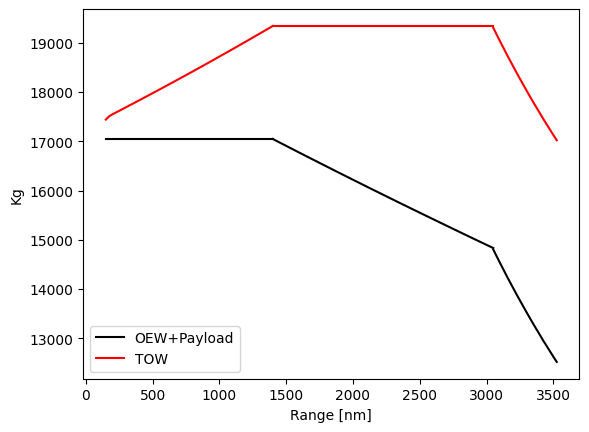

In [47]:
plt.plot(missionRangeNL,[MZFW for i in range(len(missionRangeNL))],color='black',label='OEW+Payload')
plt.plot(missionRangeNL,np.add(MZFW,wfuelNL),color='red',label='TOW')
plt.plot(missionRangeTOL,np.subtract(MTOW,wfuelTOL),color='black')
plt.plot(missionRangeTOL,[MTOW for i in range(len(missionRangeTOL))],color='red')
plt.plot(missionRangeFCL,np.add(OEW,wpayloadFCL),color='black')
plt.plot(missionRangeFCL,np.add(OEW+maxFuelCapacity,wpayloadFCL),color='red')
plt.xlabel('Range [nm]')
plt.ylabel('Kg')
plt.legend()